In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import network
import config

In [5]:
normalized_scan_100206 = np.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/normalized_scan_100206_full.npy")

In [6]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

In [7]:
big_b_indices_100206 = np.where(bvals_all_100206 != 0.005)[0]

In [8]:
bvals_100206 = bvals_all_100206[big_b_indices_100206]

In [9]:
normalized_scan_100206_no_b5 = normalized_scan_100206[:, big_b_indices_100206]

In [10]:
normalized_scan_100206_no_b5.shape

(935442, 270)

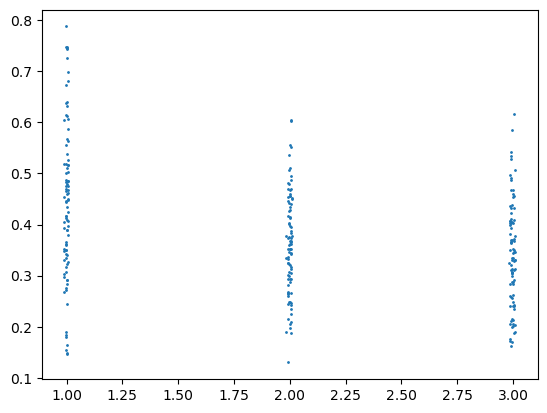

In [11]:
plt.plot(bvals_100206, normalized_scan_100206_no_b5[42,:], "o", markersize = 1)

In [12]:
n_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n_100206 = n_all_100206[:,big_b_indices_100206].T
print(n_100206.shape)

b_values_100206 = torch.FloatTensor(bvals_100206)
gradient_directions_100206 = torch.FloatTensor(n_100206)

(270, 3)


In [13]:
batch_size = 128
num_batches = len(normalized_scan_100206_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [15]:
net_golden_std = network.BallStickNet(gradient_directions_100206, b_values_100206)
net_golden_std.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_norm_01_Feb_182e.pt"))
criterion = nn.MSELoss()
optimizer = optim.Adam(net_golden_std.parameters(), lr = 0.00001)

In [17]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net_golden_std.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net_golden_std(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net_golden_std.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net_golden_std.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.84it/s]


Loss: 402.8052572624292
Average Loss: 0.05511839864017915
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.00it/s]


Loss: 402.5360245767515
Average Loss: 0.055081557823857624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.01it/s]


Loss: 402.524188939482
Average Loss: 0.05507993827852791
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 115.09it/s]


Loss: 402.67738110083155
Average Loss: 0.055100900533775525
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.65it/s]


Loss: 402.4836933501065
Average Loss: 0.05507439701014046
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.52it/s]


Loss: 402.59013629332185
Average Loss: 0.055088962273306216
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.99it/s]


Loss: 402.5120797804557
Average Loss: 0.05507828130548107
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 107.31it/s]


Loss: 402.58201727597043
Average Loss: 0.055087851296657143
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.39it/s]


Loss: 402.50096762459725
Average Loss: 0.055076760758702416
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.45it/s]


Loss: 402.6439540402498
Average Loss: 0.055096326497023784
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 5


  2%|██▌                                                                                                                                                           | 118/7308 [00:03<01:04, 112.33it/s]

X_batch: 
torch.Size([128, 270])
tensor([[0.3755, 0.5888, 0.3655,  ..., 0.4026, 0.2528, 0.4654],
        [0.4280, 0.2215, 0.1499,  ..., 0.4136, 0.2756, 0.1544],
        [0.6687, 0.3685, 0.1449,  ..., 0.5715, 0.5000, 0.3958],
        ...,
        [0.1637, 0.0729, 0.0429,  ..., 0.1641, 0.0940, 0.0385],
        [0.1978, 0.1098, 0.0713,  ..., 0.1981, 0.0975, 0.0874],
        [0.4883, 0.2126, 0.1777,  ..., 0.4848, 0.2872, 0.1471]])
X_pred: 
torch.Size([128, 270])
tensor([[0.4362, 0.4916, 0.3631,  ..., 0.4916, 0.2401, 0.4343],
        [0.4567, 0.2287, 0.1648,  ..., 0.4546, 0.2417, 0.1433],
        [0.6350, 0.3545, 0.0802,  ..., 0.5385, 0.4770, 0.4436],
        ...,
        [0.1670, 0.0729, 0.0495,  ..., 0.1633, 0.0754, 0.0652],
        [0.2002, 0.1087, 0.0813,  ..., 0.1971, 0.1003, 0.0965],
        [0.4720, 0.2284, 0.1505,  ..., 0.4566, 0.2688, 0.1173]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.15it/s]


Loss: 402.5569317128975
Average Loss: 0.055084418679925765
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.48it/s]


Loss: 402.4257866276894
Average Loss: 0.05506647326596735
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.48it/s]


Loss: 402.6682149153203
Average Loss: 0.055099646266464186
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.70it/s]


Loss: 402.43949068151414
Average Loss: 0.05506834847858705
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.83it/s]


Loss: 402.42088625230826
Average Loss: 0.05506580271651728
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:41<00:00, 72.01it/s]


Loss: 402.35175852058455
Average Loss: 0.05505634353045766
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.20it/s]


Loss: 402.4625108856708
Average Loss: 0.05507149847915583
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.97it/s]


Loss: 402.4488418849651
Average Loss: 0.055069628063076775
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.37it/s]


Loss: 402.4348992856685
Average Loss: 0.0550677202087669
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.08it/s]


Loss: 402.3081395656336
Average Loss: 0.05505037487214472
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.19it/s]


Loss: 402.57211447204463
Average Loss: 0.055086496233175235
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.77it/s]


Loss: 402.31358706764877
Average Loss: 0.05505112028840295
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.90it/s]


Loss: 402.28463357756846
Average Loss: 0.05504715839868205
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 115.07it/s]


Loss: 402.6170727047138
Average Loss: 0.05509264815335438
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.35it/s]


Loss: 402.282527776435
Average Loss: 0.05504687024855433
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.90it/s]


Loss: 402.26459412137046
Average Loss: 0.055044416272765524
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.56it/s]


Loss: 402.51970357540995
Average Loss: 0.05507932451770799
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.39it/s]


Loss: 402.28190046572126
Average Loss: 0.05504678440964987
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.95it/s]


Loss: 402.50527922506444
Average Loss: 0.05507735074234598
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.46it/s]


Loss: 402.35132664768025
Average Loss: 0.05505628443454848
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.15it/s]


Loss: 402.46665186807513
Average Loss: 0.0550720651160475
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.91it/s]


Loss: 402.3946483202744
Average Loss: 0.055062212413830657
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.14it/s]


Loss: 402.3964979851153
Average Loss: 0.055062465515204606
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.57it/s]


Loss: 402.59921242226847
Average Loss: 0.05509020421760652
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.55it/s]


Loss: 402.10441525350325
Average Loss: 0.0550224979821433
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.88it/s]


Loss: 402.1202287855558
Average Loss: 0.055024661848050875
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.26it/s]


Loss: 402.38480463111773
Average Loss: 0.05506086543939761
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.74it/s]


Loss: 402.24644333310425
Average Loss: 0.055041932585263305
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.98it/s]


Loss: 402.2189793577418
Average Loss: 0.05503817451529033
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.03it/s]


Loss: 402.40302297542803
Average Loss: 0.0550633583710219
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.60it/s]


Loss: 402.70834447373636
Average Loss: 0.05510513744851346
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.10it/s]


Loss: 402.14036076841876
Average Loss: 0.055027416634977934
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.33it/s]


Loss: 402.1208698975388
Average Loss: 0.05502474957547055
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.53it/s]


Loss: 402.25794010143727
Average Loss: 0.05504350576100674
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.16it/s]

Loss: 402.40255253156647
Average Loss: 0.05506329399720395
Done, best loss: 402.10441525350325
Done


<All keys matched successfully>